In [1]:
import pandas as pd
import numpy as np
from scipy.signal import detrend
from scipy.stats import norm
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import warnings
from functions import Hill_pro
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
url = '../data/model_out/SimpleModelBulkRun.csv'
bulk = pd.read_csv(url)
bulk = bulk.add_suffix('r')
bulk = bulk.add_prefix('_')
bulk = bulk.apply(pd.to_numeric, errors = 'coerce')
delta = bulk.filter(regex='Deltas_', axis=1)
print(str(len(delta.T)) + " runs")

delta['Delta_mean'] = delta.mean(axis=1)
delta['Delta_median'] = delta.median(axis=1)
delta['Delta_max'] = delta.max(axis=1)
delta['Delta_min'] = delta.min(axis=1)
delta['Delta_1_quant'] = np.percentile(delta, q=25, axis=1)
delta['Delta_3_quant'] = np.percentile(delta, q=75, axis=1)
delta.dropna(inplace=True)
print("delta means " + str(delta['Delta_mean']))

vola = bulk.filter(regex='_Volatility_', axis=1).dropna().T
vola.columns = ['vPrice','vReturn']

hill = bulk.filter(regex='_hillIdx', axis=1).iloc[1:].dropna()
hill.set_index(pd.Index(bulk['_hillObs_2r'].iloc[1:].dropna()), inplace=True)
hill['mean'] = hill.mean(axis=1)

hill_idx = bulk.filter(regex='_Hill_', axis=1).iloc[1:].dropna()
hill_idx['mean'] = hill_idx.mean(axis=1)

acc = bulk.filter(regex='_AACFr', axis=1).iloc[1:].dropna()
acc['mean'] = acc.mean(axis=1)

acc_idx = bulk.filter(regex='_AACr_', axis=1).iloc[1:].dropna()
acc_idx['mean'] = acc_idx.mean(axis=1)

10 runs
delta means 0    0.709640
1    0.576769
2    0.123861
3    1.428289
Name: Delta_mean, dtype: float64


In [4]:
returns = bulk.filter(regex='_Returns_', axis=1)
norm_returns = returns / returns.std()

ac_df = pd.DataFrame()

for col in returns.columns:
    acf_result = acf(returns[col], nlags=100, fft=True)
    ac_df[col] = acf_result[1:]

ac_df['mean'] = ac_df.mean(axis=1)

In [5]:
diff = abs(delta.iloc[0, :-6] - delta['Delta_median'].iloc[0])
mean_number = diff.idxmin().split('_')[2]
mean_str = '_' + mean_number
mean_run = bulk.filter(regex=mean_str, axis=1)
mean_run.columns = mean_run.columns.str.split('_').str.get(1)
mean_run['MarketFlow'] =  mean_run['MarketCount'].diff().rolling(28).sum()

diff = abs(delta.iloc[0, :-6] - delta['Delta_1_quant'].iloc[0])
q1_number = diff.idxmin().split('_')[2]
q1_str = '_' + q1_number
q1_run = bulk.filter(regex=q1_str, axis=1)
q1_run.columns = q1_run.columns.str.split('_').str.get(1)
q1_run['MarketFlow'] =  q1_run['MarketCount'].diff().rolling(28).sum()

diff = abs(delta.iloc[0, :-6] - delta['Delta_3_quant'].iloc[0])
q3_number = diff.idxmin().split('_')[2]
q3_str = '_' + q3_number
q3_run = bulk.filter(regex=q3_str, axis=1)
q3_run.columns = q3_run.columns.str.split('_').str.get(1)
q3_run['MarketFlow'] =  q3_run['MarketCount'].diff().rolling(28).sum()

In [6]:
row_idx = 0
only_Deltas = delta.iloc[0, :-6]

iqr = delta['Delta_3_quant'] - delta['Delta_1_quant']

low_limit = delta['Delta_1_quant'].iloc[row_idx] - 1.5 * iqr
low_row = only_Deltas[only_Deltas >= low_limit.iloc[row_idx]]
low_idx = low_row.idxmin().split('_')[2]
low_str = '_' + low_idx
low_run = bulk.filter(regex=low_str, axis=1)
low_run.columns = low_run.columns.str.split('_').str.get(1)
low_run['MarketFlow'] =  low_run['MarketCount'].diff().rolling(28).sum()

up_limit = delta['Delta_3_quant'].iloc[row_idx] + 1.5 * iqr
up_row = only_Deltas[only_Deltas <= up_limit.iloc[row_idx]]
up_idx = low_row.idxmax().split('_')[2]
up_str = '_' + up_idx
up_run = bulk.filter(regex=up_str, axis=1)
up_run.columns = up_run.columns.str.split('_').str.get(1)
up_run['MarketFlow'] =  up_run['MarketCount'].diff().rolling(28).sum()


In [9]:
asset = pd.read_csv('../data/BTC/bitcoin_2010.csv')
asset = asset.reindex(index=asset.index[::-1])
asset.reset_index(inplace=True, drop=True)
asset['Date'] =  pd.to_datetime(asset['Date'])
print('Data Imported with ' + str(len(asset)) + ' rows')

start = asset['Date'] >= pd.to_datetime('2012-01-01')
stop = asset['Date'] < pd.to_datetime('2023-01-01')
asset = asset[start]
asset = asset[stop]
print('Data trimmed to start & end date')

asset['logPrice'] = np.log(asset.Close)
asset['logDiff'] = detrend(asset.logPrice)
asset['Returns'] = asset.logDiff.diff()
asset['normReturns'] = asset['Returns'] / asset.Returns.std()

data = asset[['Date','Close','logPrice','logDiff','Returns']].dropna().reset_index(drop=True)
data['Date'] =  pd.to_datetime(data['Date'])

t = data['Returns'].to_numpy()
tail =  Hill_pro(t, 10)
hill_btc = pd.DataFrame(tail)
hill_btc.rename(columns = {0:'tail'}, inplace = True)
hill_btc['obs_pc'] = hill_btc.index / len(t) * 100

lag = 100
aac_btc = acf(abs(data.Returns), nlags=lag)
ac_btc = acf((data.Returns), nlags=lag)

Data Imported with 4581 rows
Data trimmed to start & end date


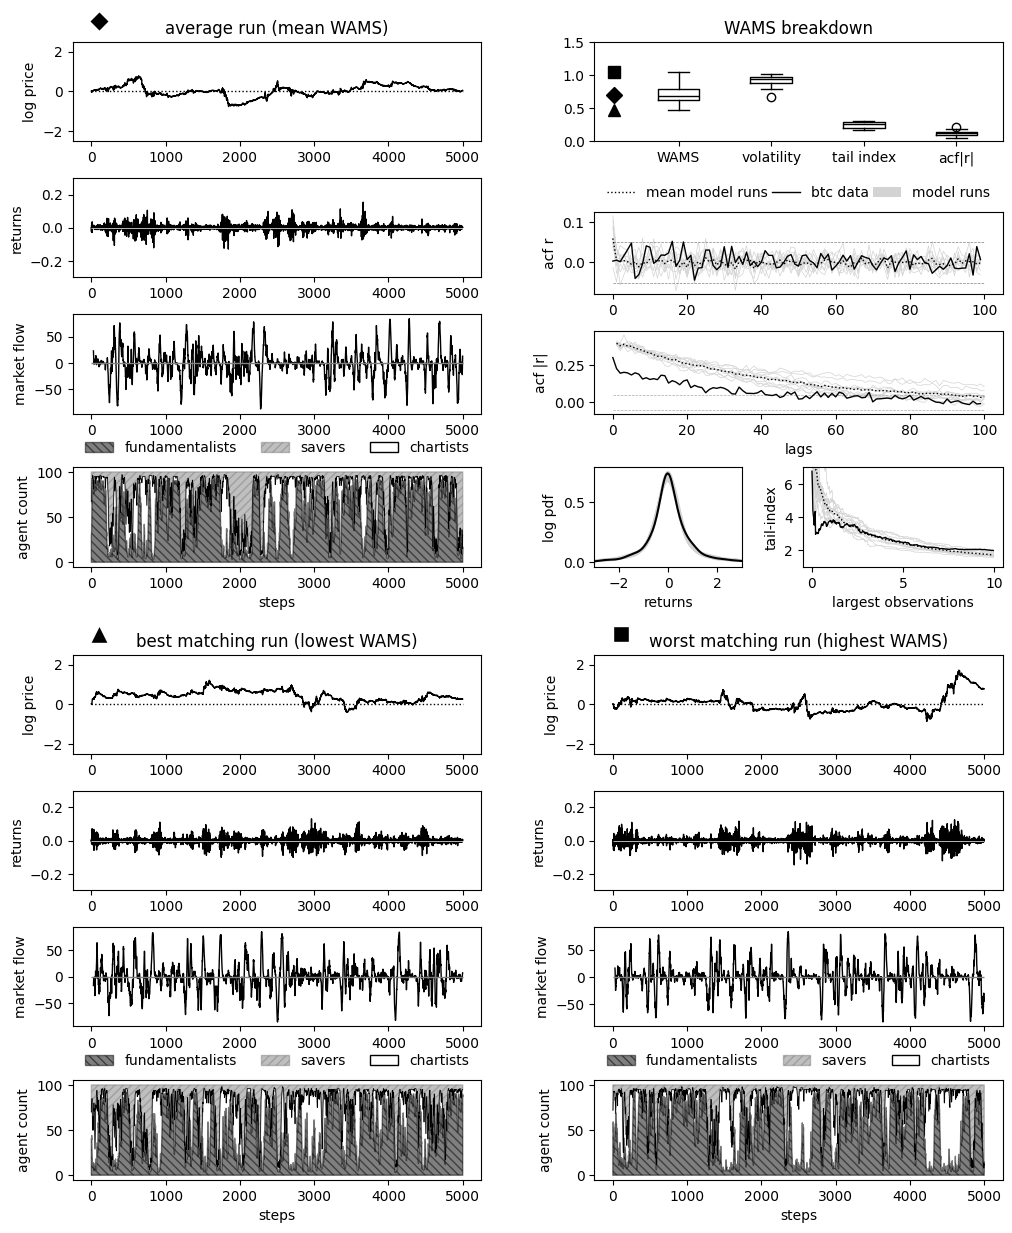

In [10]:
fig = plt.figure(figsize=(12,15))
gs = GridSpec(68, 18)

#BOX Plots
ax13 = plt.subplot(gs[1:7, 10:18])
ax13.title.set_text('WAMS breakdown')
delta_plt = delta.iloc[0:5,:-6].T
delta_plt.columns = ['WAMS','volatility','hillidx','ACabsR']
delta_plt['volatility'] = delta_plt['volatility'].apply(lambda x: x / (0.2125 * 3))
delta_plt['hillidx'] = delta_plt['hillidx'].apply(lambda x: x / (0.1674 * 3))
delta_plt['ACabsR'] = delta_plt['ACabsR'].apply(lambda x: x / (3.8845 * 3))
pos = [2,3,4,5]
box_a = ax13.boxplot(delta_plt,positions=pos)
for median in box_a['medians']:
    median.set_color('black')
ax13.plot(1.3, mean_run.Deltas[0],'D', color='black', markersize=8)
ax13.plot(1.3, up_run.Deltas[0],'s', color='black', markersize=8)
ax13.plot(1.3, low_run.Deltas[0],'^', color='black', markersize=8)
ax13.set_xticklabels(['WAMS','volatility','tail index','acf|r|'])
ax13.set_ylim(0,1.5)


# Tail Index, PDF & ACFs
ax17 = plt.subplot(gs[26:32, 10:13])
for i, col in enumerate(norm_returns.columns):
    norm_returns[col].plot(kind='density', ax=ax17, color='lightgrey')
asset.normReturns.plot.kde(color='black')
# avg = norm_returns.iloc[1:].stack()
# avg.plot(kind='density', ax=ax17, color='black', linestyle='dotted', linewidth=1)
ax17.set_xlim(-3,3)
ax17.set_ylabel('log pdf')
ax17.set_xlabel('returns')


ax15 = plt.subplot(gs[26:32, 14:18])
ax15.plot(hill, color='lightgrey', linewidth=0.5, label='_model runs')
ax15.plot(hill['mean'], color='black', linewidth=1, linestyle='dotted', label='mean model runs')
ax15.plot(hill_btc['obs_pc'],hill_btc['tail'], color='black', linewidth=1, label='btc data')
ax15.set_ylim(1,7)
ax15.set_ylabel('tail-index')
ax15.set_xlabel('largest observations')
# lgd = ax15.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax15 = legend.axes

    handles, labels = ax15.get_legend_handles_labels()
    handles.append(Patch(facecolor='lightgrey', label='model runs'))
    labels.append("model runs")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
# add_patch(lgd)

ax18 = plt.subplot(gs[11:16, 10:18])
ax18.plot(ac_df, color='lightgrey', linewidth=0.5, label='_model runs')
ax18.hlines(y=0.05, xmin=0, xmax=100, linewidth=0.5,linestyle='dashed', color='grey')
ax18.hlines(y=-0.05, xmin=0, xmax=100, linewidth=0.5,linestyle='dashed', color='grey')
ax18.plot(ac_df['mean'], color='black', linewidth=1, linestyle='dotted', label='mean model runs')
ax18.plot(ac_btc[1:], color='black', linewidth=1, label='btc data')
ax18.set_ylabel('acf r')
# ax18.set_xlabel('lags')
lgd = ax18.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax16 = legend.axes

    handles, labels = ax16.get_legend_handles_labels()
    handles.append(Patch(facecolor='lightgrey', label='model runs'))
    labels.append("model runs")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

ax16 = plt.subplot(gs[18:23, 10:18])
ax16.plot(acc, color='lightgrey', linewidth=0.5, label='_model runs')
ax16.hlines(y=0.05, xmin=0, xmax=100, linewidth=0.5,linestyle='dashed', color='darkgrey')
ax16.hlines(y=-0.05, xmin=0, xmax=100, linewidth=0.5,linestyle='dashed', color='darkgrey')
ax16.plot(acc['mean'], color='black', linewidth=1, linestyle='dotted', label='mean model runs')
ax16.plot(aac_btc[1:], color='black', linewidth=1, label='btc data')
ax16.set_ylabel('acf |r|')
ax16.set_xlabel('lags')
#lgd = ax16.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax16 = legend.axes

    handles, labels = ax16.get_legend_handles_labels()
    handles.append(Patch(facecolor='lightgrey', label='model runs'))
    labels.append("model runs")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
#add_patch(lgd)

# MODEL RUNS #####################################
# MEAN Runs Plots ################################
ax1 = plt.subplot(gs[1:7, 0:8])
ax1.title.set_text('average run (mean WAMS)')
ax1.plot(mean_run.logPrice, color='black', linewidth=1)
ax1.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='black', linestyle='dotted')
ax1.set_ylabel('log price')
element = [Line2D([0], [0], marker='D', color='w', markerfacecolor='black', markersize=10)]
ax1.legend(handles=element, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", frameon=False)
ax1.set_ylim(-2.5,2.5)

ax2 = plt.subplot(gs[9:15, 0:8])
ax2.plot(mean_run.Returns, color='black', linewidth=1)
ax2.hlines(y=0, xmin=0, xmax=5000, linewidth=0.5, color='white')
ax2.set_ylabel('returns')
ax2.set_ylim(-0.3, 0.3)

ax3 = plt.subplot(gs[17:23, 0:8])
ax3.plot(mean_run.MarketFlow, color='black', linewidth=1)
ax3.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='grey')
ax3.set_ylabel('market flow')

ax4 = plt.subplot(gs[26:32, 0:8])
#ax4.plot(best_run.ChartCount, color='white', linewidth=0.1)
ax4.fill_between(mean_run.index, mean_run.FundCount, 0, color='black', alpha=0.5, hatch='\\\\\\\\',  label='fundamentalists')
ax4.fill_between(mean_run.index, mean_run.MarketCount, mean_run.AgentCount, color='grey', alpha=0.5, hatch='////',  label='savers')
ax4.plot(mean_run.MarketCount, color='black', linewidth=0.5)
ax4.set_ylabel('agent count')
ax4.set_xlabel('steps')
lgd = ax4.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax4 = legend.axes

    handles, labels = ax4.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='chartists'))
    labels.append("chartists")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

# lowest WAMS (best run)
ax9 = plt.subplot(gs[37:43, 0:8])
ax9.title.set_text('best matching run (lowest WAMS)')
ax9.plot(low_run.logPrice, color='black', linewidth=1)
ax9.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='black', linestyle='dotted')
ax9.set_ylabel('log price')
element = [Line2D([0], [0], marker='^', color='w', markerfacecolor='black', markersize=13)]
ax9.legend(handles=element, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", frameon=False)
ax9.set_ylim(-2.5,2.5)

ax10 = plt.subplot(gs[45:51, 0:8])
ax10.plot(low_run.Returns, color='black', linewidth=1)
ax10.hlines(y=0, xmin=0, xmax=5000, linewidth=0.5, color='white')
ax10.set_ylabel('returns')
ax10.set_ylim(-0.3, 0.3)

ax11 = plt.subplot(gs[53:59, 0:8])
ax11.plot(low_run.MarketFlow, color='black', linewidth=1)
ax11.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='grey')
ax11.set_ylabel('market flow')
# ax11.set_ylim(ax3.get_ylim())

ax12 = plt.subplot(gs[62:68, 0:8])
# ax12.plot(mid_run.ChartCount, color='black', linewidth=0.1)
ax12.fill_between(low_run.index, low_run.FundCount, 0, color='black', alpha=0.5, hatch='\\\\\\\\', label='fundamentalists')
ax12.fill_between(low_run.index, low_run.MarketCount, low_run.AgentCount, color='grey', alpha=0.5, hatch='////', label='savers')
ax12.plot(low_run.MarketCount, color='black', linewidth=0.5)
ax12.set_ylabel('agent count')
ax12.set_xlabel('steps')
lgd = ax12.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax12 = legend.axes

    handles, labels = ax12.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='chartists'))
    labels.append("chartists")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

# highest WAMS (worst Run)
ax5 = plt.subplot(gs[37:43, 10:18])
ax5.title.set_text('worst matching run (highest WAMS)')
ax5.plot(up_run.logPrice, color='black', linewidth=1)
ax5.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='black', linestyle='dotted')
ax5.set_ylabel('log price')
element = [Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markersize=12)]
ax5.legend(handles=element, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", frameon=False)
ax5.set_ylim(-2.5,2.5)

ax6 = plt.subplot(gs[45:51, 10:18])
ax6.plot(up_run.Returns, color='black', linewidth=1)
ax6.hlines(y=0, xmin=0, xmax=5000, linewidth=0.5, color='white')
ax6.set_ylabel('returns')
ax6.set_ylim(-0.3, 0.3)
# ax6.set_ylim(ax2.get_ylim())
ax7 = plt.subplot(gs[53:59, 10:18])
ax7.plot(up_run.MarketFlow, color='black', linewidth=1)
ax7.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='grey')
ax7.set_ylabel('market flow')
# ax7.set_ylim(ax3.get_ylim())

ax8 = plt.subplot(gs[62:68, 10:18])
# ax8.plot(worst_run.MarketCount, color='gray', linewidth=0.1)
ax8.fill_between(up_run.index, up_run.FundCount, 0, color='black', alpha=0.5, hatch='\\\\\\\\', label='fundamentalists')
ax8.fill_between(up_run.index, up_run.MarketCount, up_run.AgentCount, color='grey', alpha=0.5, hatch='////', label='savers')
ax8.plot(up_run.MarketCount, color='black', linewidth=0.5)
ax8.set_xlabel('steps')
ax8.set_ylabel('agent count')
lgd = ax8.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax8 = legend.axes

    handles, labels = ax8.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='chartists'))
    labels.append("chartists")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

# plt.tight_layout()
plt.show()

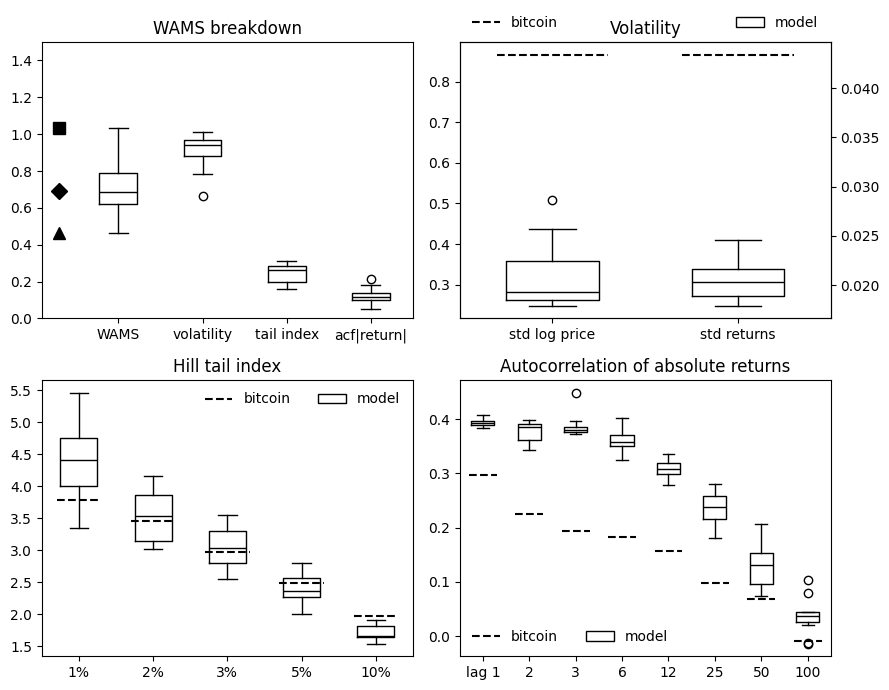

In [11]:
fig = plt.figure(figsize=(9,7))
gs = GridSpec(2, 4)

ax13 = plt.subplot(gs[0:1, 0:2])
ax13.title.set_text('WAMS breakdown')
delta_plt = delta.iloc[0:5,:-6].T
delta_plt.columns = ['WAMS','volatility','hillidx','ACabsR']
delta_plt['volatility'] = delta_plt['volatility'].apply(lambda x: x / (0.2125 * 3))
delta_plt['hillidx'] = delta_plt['hillidx'].apply(lambda x: x / (0.1674 * 3))
delta_plt['ACabsR'] = delta_plt['ACabsR'].apply(lambda x: x / (3.8845 * 3))
pos = [2,3,4,5]
box_a = ax13.boxplot(delta_plt,positions=pos)
for median in box_a['medians']:
    median.set_color('black')
ax13.plot(1.3, mean_run.Deltas[0],'D', color='black', markersize=8)
ax13.plot(1.3, up_run.Deltas[0],'s', color='black', markersize=8)
ax13.plot(1.3, low_run.Deltas[0],'^', color='black', markersize=8)
ax13.set_xticklabels(['WAMS','volatility','tail index','acf|return|'])
ax13.set_ylim(0,1.5)


ax1 = plt.subplot(gs[0:1, 2:4])
ax1.title.set_text('Volatility')
box_b1 = ax1.boxplot(vola.vPrice, positions=[1],widths=.5)
for median in box_b1['medians']:
    median.set_color('black')
ax21 = ax1.twinx()
box_b2 = ax21.boxplot(vola.vReturn, positions=[2],widths=.5)
for median in box_b2['medians']:
    median.set_color('black')
ax1.set_xticklabels(['std log price','std returns'])
ax1.hlines(y=0.86622, xmin=0.7, xmax=1.3, linewidth=1.5, color='black',linestyle='dashed', label='bitcoin')
ax21.hlines(y=0.04342, xmin=1.7, xmax=2.3, linewidth=1.5, color='black',linestyle='dashed')
# lgd = ax1.legend(frameon=False)
lgd = ax1.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=2, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax1 = legend.axes

    handles, labels = ax1.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='model'))
    labels.append("model")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)


ax2 = plt.subplot(gs[1:2, :2])
ax2.title.set_text('Hill tail index')
box_b1 = ax2.boxplot(hill_idx.T, widths=.5)
for median in box_b1['medians']:
    median.set_color('black')
ax2.set_xticklabels(['1%','2%','3%','5%','10%'])
ax2.hlines(y=3.7861, xmin=0.7, xmax=1.3, linewidth=1.5, color='black',linestyle='dashed', label='bitcoin')
ax2.hlines(y=3.46297, xmin=1.7, xmax=2.3, linewidth=1.5, color='black',linestyle='dashed')
ax2.hlines(y=2.9697, xmin=2.7, xmax=3.3, linewidth=1.5, color='black',linestyle='dashed')
ax2.hlines(y=2.4926, xmin=3.7, xmax=4.3, linewidth=1.5, color='black',linestyle='dashed')
ax2.hlines(y=1.9809, xmin=4.7, xmax=5.3, linewidth=1.5, color='black',linestyle='dashed')
lgd = ax2.legend(loc="upper right", ncol=2, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax2 = legend.axes

    handles, labels = ax2.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='model'))
    labels.append("model")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)


ax3 = plt.subplot(gs[1:2, 2:4])
ax3.title.set_text('Autocorrelation of absolute returns')
box_b1 = ax3.boxplot(acc_idx.T, widths=.5)
for median in box_b1['medians']:
    median.set_color('black')
ax3.set_xticklabels(['lag 1','2','3','6','12','25','50','100'])
ax3.hlines(y=0.2978, xmin=0.7, xmax=1.3, linewidth=1.5, color='black',linestyle='dashed', label='bitcoin')
ax3.hlines(y=0.2246, xmin=1.7, xmax=2.3, linewidth=1.5, color='black',linestyle='dashed')
ax3.hlines(y=0.1937, xmin=2.7, xmax=3.3, linewidth=1.5, color='black',linestyle='dashed')
ax3.hlines(y=0.1820, xmin=3.7, xmax=4.3, linewidth=1.5, color='black',linestyle='dashed')
ax3.hlines(y=0.1575, xmin=4.7, xmax=5.3, linewidth=1.5, color='black',linestyle='dashed')
ax3.hlines(y=0.0977, xmin=5.7, xmax=6.3, linewidth=1.5, color='black',linestyle='dashed')
ax3.hlines(y=0.0687, xmin=6.7, xmax=7.3, linewidth=1.5, color='black',linestyle='dashed')
ax3.hlines(y=-0.0093, xmin=7.7, xmax=8.3, linewidth=1.5, color='black',linestyle='dashed')
lgd = ax3.legend(loc="lower left", ncol=2, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax3 = legend.axes

    handles, labels = ax3.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='model'))
    labels.append("model")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

plt.tight_layout()
# plt.savefig(fname="simulated-vs-btc-moments.svg", format="svg")
plt.show()

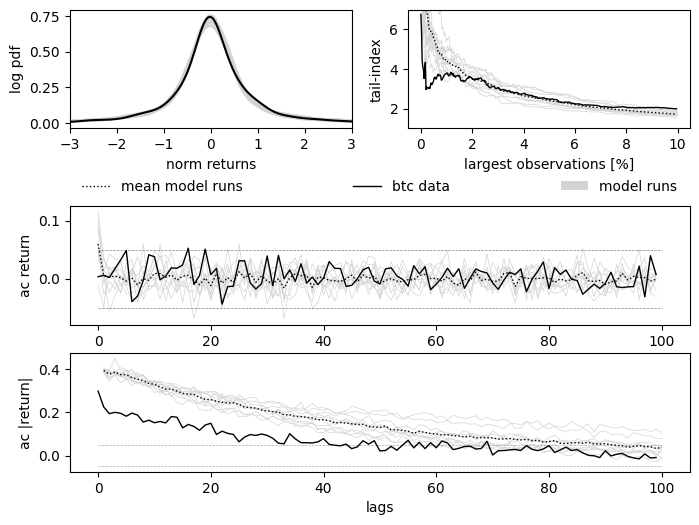

In [14]:
fig = plt.figure(figsize=(8,6), constrained_layout=True)
gs = GridSpec(19, 2)


# Tail Index, PDF & ACFs
ax17 = plt.subplot(gs[:5, :1])
for i, col in enumerate(norm_returns.columns):
    norm_returns[col].plot(kind='density', ax=ax17, color='lightgrey')
asset.normReturns.plot.kde(color='black')
# avg = norm_returns.iloc[1:].stack()
# avg.plot(kind='density', ax=ax17, color='black', linestyle='dotted', linewidth=1)
ax17.set_xlim(-3,3)
ax17.set_ylabel('log pdf')
ax17.set_xlabel('norm returns')


ax15 = plt.subplot(gs[:5, 1:])
ax15.plot(hill, color='lightgrey', linewidth=0.5, label='_model runs')
ax15.plot(hill['mean'], color='black', linewidth=1, linestyle='dotted', label='mean model runs')
ax15.plot(hill_btc['obs_pc'],hill_btc['tail'], color='black', linewidth=1, label='btc data')
ax15.set_ylim(1,7)
ax15.set_ylabel('tail-index')
ax15.set_xlabel('largest observations [%]')
# lgd = ax15.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3, frameon=False)


ax18 = plt.subplot(gs[8:13, :])
ax18.plot(ac_df, color='lightgrey', linewidth=0.5, label='_model runs')
ax18.hlines(y=0.05, xmin=0, xmax=100, linewidth=0.5,linestyle='dashed', color='grey')
ax18.hlines(y=-0.05, xmin=0, xmax=100, linewidth=0.5,linestyle='dashed', color='grey')
ax18.plot(ac_df['mean'], color='black', linewidth=1, linestyle='dotted', label='mean model runs')
ax18.plot(ac_btc[1:], color='black', linewidth=1, label='btc data')
ax18.set_ylabel('ac return')
# ax18.set_xlabel('lags')
lgd = ax18.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax16 = legend.axes

    handles, labels = ax16.get_legend_handles_labels()
    handles.append(Patch(facecolor='lightgrey', label='model runs'))
    labels.append("model runs")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

ax16 = plt.subplot(gs[14:19, :])
ax16.plot(acc, color='lightgrey', linewidth=0.5, label='_model runs')
ax16.hlines(y=0.05, xmin=0, xmax=100, linewidth=0.5,linestyle='dashed', color='darkgrey')
ax16.hlines(y=-0.05, xmin=0, xmax=100, linewidth=0.5,linestyle='dashed', color='darkgrey')
ax16.plot(acc['mean'], color='black', linewidth=1, linestyle='dotted', label='mean model runs')
ax16.plot(aac_btc[1:], color='black', linewidth=1, label='btc data')
ax16.set_ylabel('ac |return|')
ax16.set_xlabel('lags')
#lgd = ax16.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=3, frameon=False)

# plt.tight_layout()
plt.savefig(fname="Model-Runs-logPDF-Hill-AC.svg", format="svg")
plt.show()

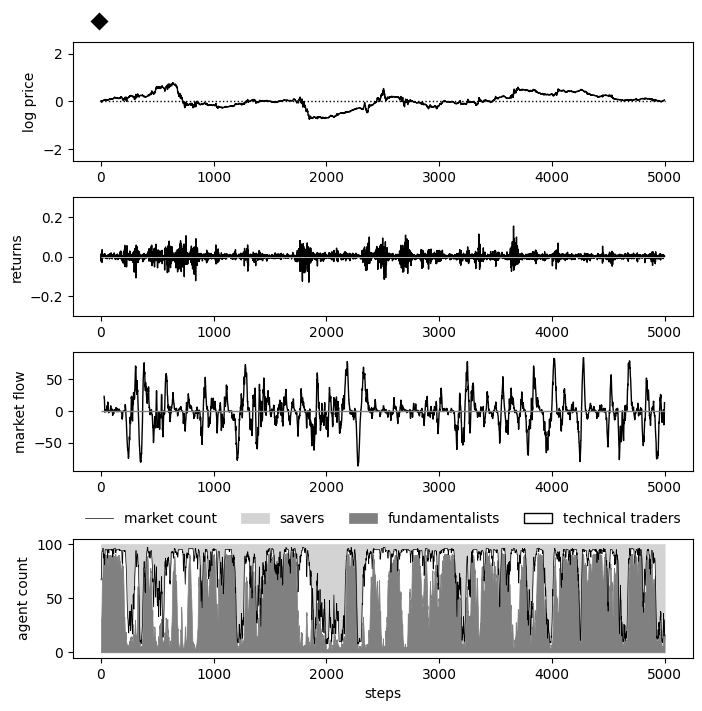

In [15]:
# MEAN Runs Plots ################################
fig = plt.figure(figsize=(8,8), constrained_layout=True)
gs = GridSpec(20, 1)

ax1 = plt.subplot(gs[:4, :])
# ax1.title.set_text('average run (mean WAMS)')
ax1.plot(mean_run.logPrice, color='black', linewidth=1)
ax1.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='black', linestyle='dotted')
ax1.set_ylabel('log price')
element = [Line2D([0], [0], marker='D', color='w', markerfacecolor='black', markersize=10)]
ax1.legend(handles=element, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", frameon=False)
ax1.set_ylim(-2.5,2.5)

ax2 = plt.subplot(gs[5:9, :])
ax2.plot(mean_run.Returns, color='black', linewidth=1)
ax2.hlines(y=0, xmin=0, xmax=5000, linewidth=0.5, color='white')
ax2.set_ylabel('returns')
ax2.set_ylim(-0.3, 0.3)

ax3 = plt.subplot(gs[10:14, :])
ax3.plot(mean_run.MarketFlow, color='black', linewidth=1)
ax3.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='grey')
ax3.set_ylabel('market flow')

ax4 = plt.subplot(gs[16:20, :])
#ax4.plot(best_run.ChartCount, color='white', linewidth=0.1)
ax4.plot(mean_run.MarketCount, color='black', linewidth=0.5, label='market count')
ax4.fill_between(mean_run.index, mean_run.MarketCount, mean_run.AgentCount, color='lightgrey', label='savers',linewidth=.5)
ax4.fill_between(mean_run.index, mean_run.FundCount, 0, color='grey', label='fundamentalists', linewidth=.5)


ax4.set_ylabel('agent count')
ax4.set_xlabel('steps')
lgd = ax4.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=4, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax4 = legend.axes

    handles, labels = ax4.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='technical traders'))
    labels.append("technical traders")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

# plt.savefig(fname="AverageRun-SimpleInflux.svg", format="svg")
plt.show()


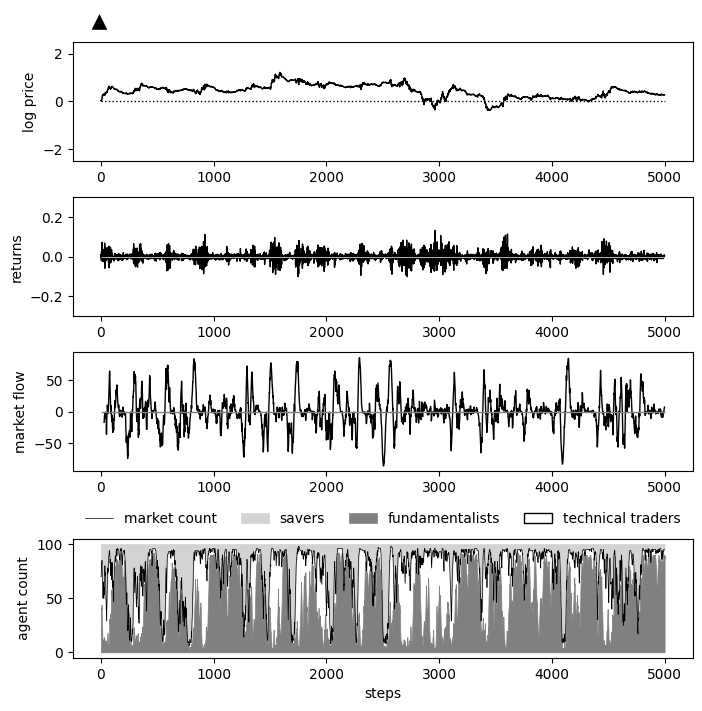

In [16]:
# lowest WAMS (best run)
fig = plt.figure(figsize=(8,8), constrained_layout=True)
gs = GridSpec(20, 1)

ax9 = plt.subplot(gs[:4, :])
# ax9.title.set_text('best matching run (lowest WAMS)')
ax9.plot(low_run.logPrice, color='black', linewidth=1)
ax9.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='black', linestyle='dotted')
ax9.set_ylabel('log price')
element = [Line2D([0], [0], marker='^', color='w', markerfacecolor='black', markersize=13)]
ax9.legend(handles=element, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", frameon=False)
ax9.set_ylim(-2.5,2.5)

ax10 = plt.subplot(gs[5:9, :])
ax10.plot(low_run.Returns, color='black', linewidth=1)
ax10.hlines(y=0, xmin=0, xmax=5000, linewidth=0.5, color='white')
ax10.set_ylabel('returns')
ax10.set_ylim(-0.3, 0.3)

ax11 = plt.subplot(gs[10:14, :])
ax11.plot(low_run.MarketFlow, color='black', linewidth=1)
ax11.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='grey')
ax11.set_ylabel('market flow')
# ax11.set_ylim(ax3.get_ylim())

ax12 = plt.subplot(gs[16:20, :])
# ax12.plot(mid_run.ChartCount, color='black', linewidth=0.1)
ax12.plot(low_run.MarketCount, color='black', linewidth=0.5, label='market count')
ax12.fill_between(low_run.index, low_run.MarketCount, low_run.AgentCount, color='lightgrey', linewidth=.5, label='savers')
ax12.fill_between(low_run.index, low_run.FundCount, 0, color='grey', label='fundamentalists', linewidth=.5)
ax12.set_ylabel('agent count')
ax12.set_xlabel('steps')
lgd = ax12.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=4, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax12 = legend.axes

    handles, labels = ax12.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='technical traders'))
    labels.append("technical traders")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

# plt.savefig(fname="BestRun-SimpleInflux.svg", format="svg")
plt.show()

In [1]:
# highest WAMS (worst Run)
fig = plt.figure(figsize=(8,8), constrained_layout=True)
gs = GridSpec(20, 1)

ax5 = plt.subplot(gs[:4, :])
# ax5.title.set_text('worst matching run (highest WAMS)')
ax5.plot(up_run.logPrice, color='black', linewidth=1)
ax5.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='black', linestyle='dotted')
ax5.set_ylabel('log price')
element = [Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markersize=12)]
ax5.legend(handles=element, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", frameon=False)
# ax5.set_ylim(-2.5,2.5)

ax6 = plt.subplot(gs[5:9, :])
ax6.plot(up_run.Returns, color='black', linewidth=1)
ax6.hlines(y=0, xmin=0, xmax=5000, linewidth=0.5, color='white')
ax6.set_ylabel('returns')
ax6.set_ylim(-0.3, 0.3)
# ax6.set_ylim(ax2.get_ylim())
ax7 = plt.subplot(gs[10:14, :])
ax7.plot(up_run.MarketFlow, color='black', linewidth=1)
ax7.hlines(y=0, xmin=0, xmax=5000, linewidth=1, color='grey')
ax7.set_ylabel('market flow')
# ax7.set_ylim(ax3.get_ylim())

ax8 = plt.subplot(gs[16:20, :])
# ax8.plot(worst_run.MarketCount, color='gray', linewidth=0.1)
ax8.plot(up_run.MarketCount, color='black', linewidth=0.5, label='market count')
ax8.fill_between(up_run.index, up_run.MarketCount, up_run.AgentCount, color='lightgrey', label='savers')
ax8.fill_between(up_run.index, up_run.FundCount, 0, color='grey', label='fundamentalists')

ax8.set_xlabel('steps')
ax8.set_ylabel('agent count')
lgd = ax8.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=4, frameon=False)
def add_patch(legend):
    from matplotlib.patches import Patch
    ax8 = legend.axes

    handles, labels = ax8.get_legend_handles_labels()
    handles.append(Patch(facecolor='white', edgecolor='black', label='technical traders'))
    labels.append("technical traders")

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())
add_patch(lgd)

# plt.savefig(fname="WorstRun-SimpleInflux.svg", format="svg")
plt.show()

NameError: name 'plt' is not defined